# AI Lab: Assignment 1

In [1]:
# Mounting the Google Drive folder (run if necessary)
from google.colab import drive
drive.mount('/content/drive/')
# Saving the present working directory's path
pwd = "/content/drive/MyDrive/ColabNotebooks/AI-Labs/AI-Assignment1/" # Present working directory

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Reading the CSV file...

In [2]:
import pandas as pd
# Reading data from the given file "tubedata.csv":
df = pd.read_csv(pwd + 'tubedata.csv', header=None)
df.head()

,0,1,2,3,4,5
0,Harrow & Wealdstone,Kenton,Bakerloo,3,5,0
1,Kenton,South Kenton,Bakerloo,2,4,0
2,South Kenton,North Wembley,Bakerloo,2,4,0
3,North Wembley,Wembley Central,Bakerloo,2,4,0
4,Wembley Central,Stonebridge Park,Bakerloo,3,4,0


Creating the graph from the given data as a dictionary...

In [3]:
from collections import defaultdict

station_dict = defaultdict(list)
zone_dict = defaultdict(set)

# Function for converting zone values from default char to integer
def _(zone):
  try: zone = int(zone)
  except: zone = {'a':7, 'b':8, 'c':9, 'd':10}[zone]
  # NOTE: The reasoning behind the above line will be seen in zone heuristics
  return zone


# Get data row by row
for index, row in df.iterrows():

  start_station = row[0]
  end_station = row[1]
  line = row[2]
  avg_time = int(row[3])

  zone1 = row[4]
  zone2 = row[5]

  if zone2 == '0': zone2 = zone1
  # Station dictionary of child station tuples...
  # ... (child name, cost from parent to the child, connecting line, zones)
  station_dict[start_station].append((end_station, avg_time, line, _(zone1), _(zone2)))
  # The following line adds the other direction of the tube "step":
  station_dict[end_station].append((start_station, avg_time, line, _(zone2), _(zone1)))

  """
  1.
  PREVIOUS CODE FOR THE ABOVE:
  station_list = station_dict[start_station]
  station_list.append((end_station, avg_time, ...))
  station_list = station_dict[end_station]
  station_list.append((start_station, avg_time, ...))


  WHY IT HAS THE SAME EFFECT AS THE CURRENT CODE:
  An identifier of a list references not a value but a memory location (of the
  base address). Thus, assigning a list object to another identifier passes the
  same location, thus preserving the reference to the value. Thus, changing the
  newly assigned list object's values or adding/removing values also changes
  the original list object in the same way, as we are operating from the same
  base address.

  ================================================

  2.
  NOTE ON ZONE MAPPING:
  We are assigning zoneMap_dict elements such that:
  - zone1 is the starting station's connecting point's zone
  - zone2 is the ending station's connecting point's zone
  (connecting point with respect to the above stations' link)

  If zone2 is 0, it means the ending station's connection point's zone is the
  same as it is for the starting station. If not, then the assignments mirror
  each other; starting station to ending station ==> zone1 to zone2, and
  ending station to starting station ==> zone2 to zone1
  """

  # Storing the zones per station for future reference:
  zone_dict[start_station], zone_dict[end_station] = set(), set()
  # Adding the main zone:
  zone_dict[start_station].add(zone1)
  # Adding the secondary zone:
  if zone2 != '0':
    zone_dict[start_station].add(zone2)
    # If the secondary zone is not 0, it is the ending station's main zone:
    zone_dict[end_station].add(zone2)
  else:
    # Else ending station's main zone is the same as for the starting station:
    zone_dict[end_station].add(zone1)

Having a look at the created data...

In [4]:
# Printing the 1st 5 items of avt_time_dict:
for key in list(station_dict.keys())[:5]: print(f"{key}: {station_dict[key]}")

Harrow & Wealdstone: [('Kenton', 3, 'Bakerloo', 5, 5)]
Kenton: [('Harrow & Wealdstone', 3, 'Bakerloo', 5, 5), ('South Kenton', 2, 'Bakerloo', 4, 4)]
South Kenton: [('Kenton', 2, 'Bakerloo', 4, 4), ('North Wembley', 2, 'Bakerloo', 4, 4)]
North Wembley: [('South Kenton', 2, 'Bakerloo', 4, 4), ('Wembley Central', 2, 'Bakerloo', 4, 4)]
Wembley Central: [('North Wembley', 2, 'Bakerloo', 4, 4), ('Stonebridge Park', 3, 'Bakerloo', 4, 4)]


In [5]:
# Printing the 1st 5 items of zone_dict
for key in list(zone_dict.keys())[:5]: print(f"{key}: {zone_dict[key]}")

Harrow & Wealdstone: {'5'}
Kenton: {'4'}
South Kenton: {'4'}
North Wembley: {'4'}
Wembley Central: {'4'}


## 2. Implementing agenda-based search

An agenda in general refers to a list (ordered set) of items to be processed in a well-defined order. In the case of search, agenda refers to the list of nodes to be explored in a well-defined order; the nodes chosen to be explored as well as the order of exploration depends on the search method.<br><br>The agenda-based search methods we are looking into are:

- Breadth-first search (BFS)
  - Agenda: FIFO queue of unexpanded nodes
  - Order: First-come-first-serve
- Depth-first search (DFS)
  - Agenda: LIFO queue of unexpanded nodes
  - Order: Last-come-first-serve
- Uniform cost search (UCS) (extension of BFS)
  - Agenda: Queue ordered by cost
  - Order: Least cost first

Dependencies...

In [6]:
# Simple helper function to present search results conveniently:
def printSearchResults(returnValue:dict,
                       params=["path", "pathCost", "nExpandedNodes"]):
  for p in params:
    print(p + ":", returnValue[p])

# GLOBAL CONSTANTS:
"""
The following correspond to the indices of the name, average time cost, line &
zones for each item of `station_dict`.
"""
iNAME, iTIME, iLINE, iZ1, iZ2 = 0, 1, 2, 3, 4
# NOTE: This is to improve the readability of the code

### 2.1. Implementing BFS, DFS & UCS

#### 2.1.a. Breadth-first search (BFS)

In [7]:
def BFS(graph, initial, goal):
  """
  graph: a dictionary like `station_dict`
  initial: string, i.e. name of initial station
  goal: string, i.e. name of goal
  """

  # Checking if we are already at the goal:
  if initial == goal: return {"path": [initial],
                              "pathCost":0,
                              "nExpandedNodes":0}

  # Initialising the search tree:
  visited, nExpandedNodes = [initial], 0
  curPaths = [([initial], 0)]
  # INTENDED FORMAT OF EACH ELEMENT:
  # (path, path cost),
  # where path=list of nodes

  while True:
    newPaths = []
    for i, P in enumerate(curPaths):
      path, pathCost = P[0], P[1]
      curNode = path[-1]
      # Getting neighbors of this node not already visited:
      children = [child for child in graph[curNode]
                  if child[iNAME] not in visited]
      """
      NOTE ON THE FORMAT OF ELEMENTS OF `children`:
      Each element of `children` will be of the form
      (next, transition cost, line, zone1, zone2),
      where:
        - next is a string (the name of the station, i.e. child node)
        - transition cost is the cost from `nodeToExplore` to the `next`
        - line is the connecting line between the nodes
        - zones 1 & 2 are the zones of the connection points of the stations
      """
      # Marking `nodeToExplore` as explored:
      nExpandedNodes += 1 # Updating the statistic

      # Checking that deadend has not been reached:
      if children != []: # True ==> Deadend not reached; add new paths
        # Generating all forks from this point:
        for child in children:
          nextNode, stepCost = child[0], child[1]
          # If the goal is found, add it to `path` & return the new path:
          if nextNode == goal:
            path += [nextNode]
            pathCost += stepCost
            return {"path":path,
                    "pathCost":pathCost,
                    "nExpandedNodes":nExpandedNodes}

          # If the goal is not found, create a new path:
          newPaths.append((path + [nextNode], pathCost + stepCost))
          """
          COMMENT ON THE ABOVE LINE:
          Here, we generate the fork [path[-1], child].
          Then, we create a new path from the existing path "path".
          """
          visited.append(nextNode)
          """
          COMMENT ON STORING VISITED NODES:
          we are storing whole paths along with the final node which is
          either unexpanded or a deadend, i.e. adding the node to the path as
          soon as we visit them (not just when we explore them), we need to
          store all visited nodes & not just explored ones to ensure that
          other paths do not traverse over the same nodes (potentially
          generating redundant pathways)
          """
    # Checking if no new nodes were added:
    if newPaths == []: break # If all end nodes are deadends
    else: curPaths = newPaths

  # If the goal cannot be found:
  return {"path":[],
          "pathCost":float("nan"),
          "nExpandedNodes":nExpandedNodes}

In [8]:
printSearchResults(BFS(station_dict, "Euston", "Victoria"))

path: ['Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria']
pathCost: 7
nExpandedNodes: 26


#### 2.1.b. Depth-first search (DFS)

In [9]:
def DFS(graph, initial, goal,                                # Main args
        path=[], expanded=[], pathCost=0, nExpandedNodes=0): # Default args
  # Resetting the default list arguments if necessary:
  # NOTE: This helps when calling DFS more than once
  if nExpandedNodes == 0: expanded, path = [initial], []

  # Checking if we are already at the goal:
  if initial == goal:
    path.append(goal)
    return {"path":path,
            "pathCost":pathCost,
            "nExpandedNodes":nExpandedNodes}

  children = [child for child in graph[initial] if child[iNAME] not in expanded]
  """
  NOTE ON THE FORMAT OF ELEMENTS OF `children`:
  Same as in the BFS function.
  """

  expanded.append(initial)
  nExpandedNodes += 1

  for child in children:
    r = DFS(graph, child[iNAME], goal, path, expanded, pathCost, nExpandedNodes)
    nExpandedNodes = r["nExpandedNodes"]
    # Checking if goal is reached:
    if r["path"] != []: # True ==> Goal reached; update path & statistics
      path.insert(0, initial)
      pathCost = r["pathCost"] + child[iTIME]
      return {"path":path,
              "pathCost":pathCost,
              "nExpandedNodes":nExpandedNodes}
      # NOTE: r[1] contains the updated `nExpandedNodes` statistic

  # Goal cannot be found:
  return {"path":[],
          "pathCost":float("nan"),
          "nExpandedNodes":nExpandedNodes}

In [10]:
printSearchResults(DFS(station_dict, "Euston", "Victoria"))

path: ['Euston', 'Warren Street', 'Goodge Street', 'Tottenham Court Road', 'Oxford Circus', "Regent's Park", 'Baker Street', 'Marylebone', 'Edgware Road', 'Paddington', 'Bayswater', 'Notting Hill Gate', 'Holland Park', "Shepherd's Bush", 'White City', 'East Acton', 'North Acton', 'West Acton', 'Ealing Broadway', 'Ealing Common', 'Acton Town', 'Chiswick Park', 'Turnham Green', 'Stamford Brook', 'Ravenscourt Park', 'Hammersmith', 'Barons Court', 'West Kensington', "Earls' Court", 'High Street Kensington', 'Gloucester Road', 'South Kensington', 'Sloane Square', 'Victoria']
pathCost: 69
nExpandedNodes: 87


#### 2.1.c. Uniform cost search (UFS)

Dependencies...

In [11]:
# 1. Importing the priority queue implementation:
from queue import PriorityQueue
"""
NOTE ON PriorityQueue:
This is a class that implements the priority queue data structure.
Items are ordered (by default in ascending order) based on the values or
(in case of tuple items) the value of the item's first element.
"""
#------------------------------------------------
# 2. Step cost calculation function:
def getStepCost(path, child, graph=None):
  # NOTE: Line-based cost is considered only if `graph` is not `None` or `False`

  # CASE 1: If changing line cost must not be considered:
  if graph == None or graph == False or len(path) < 2: return child[iTIME]

  # CASE 2: If changing line cost must be considered:
  curNode, prevNode, i = path[-1], path[-2], 0
  # Obtaining the lines for current & previous steps:
  # NOTE: We assume that `line_dict` is defined outside the function
  while graph[prevNode][i][iNAME] != curNode: i += 1 # Line for previous step
  prevLine, curLine = graph[prevNode][i][iLINE], child[iLINE]

  # Returning the step cost based on whether line change occurred:
  if prevLine == curLine: return child[iTIME]
  return child[iTIME] + 2 # We fix 2 as the line change cost

Main function...

In [12]:
# The UCS function:
def UCS(graph, initial, goal, considerLineChange=False):
  # NOTE: Line-based cost is considered only if the last argument is True
  """
  graph: a dictionary like `station_dict`
  initial: string, i.e. name of initial station
  goal: string, i.e. name of goal
  """

  # Checking if we are already at the goal:
  if initial == goal: return {"path":[initial],
                              "pathCost":0,
                              "nExpandedNodes":nExpandedNodes}

  # If line change must be considered:
  if considerLineChange: considerLineChange = graph

  # Initialising the search tree:
  visited, nExpandedNodes = [], 0
  curPaths = PriorityQueue()
  curPaths.put((0, [initial]))
  # INTENDED FORMAT OF EACH ELEMENT:
  # (priority, path),
  # where priority=path cost, path=list of nodes

  # Main loop:
  while not curPaths.empty():
    # Getting the highest priority path (i.e. the one with the lowest cost):
    pathCost, path = curPaths.get()
    # Selecting the tail of this path as the node to explore:
    curNode = path[-1]
    # Getting neighbors of this node not already visited (with transition cost):
    children = [child for child in graph[curNode]
                if child[iNAME] not in visited]
    """
    NOTE ON THE FORMAT OF ELEMENTS OF `children`:
    Same as in the BFS function.
    """
    # Marking `nodeToExplore` as explored:
    nExpandedNodes += 1 # Updating the statistic

    # Checking that deadend has not been reached:
    if children != []: # Deadend not reached; add new paths
      # Generating all forks from this point:
      for child in children:
        nextNode = child[iNAME]
        nextLine = child[iLINE]
        stepCost = getStepCost(path, child, considerLineChange)
        # NOTE: Line-based cost is considered only if the last argument is True

        # If the goal is found, add it to `path` & return the new path:
        if nextNode == goal:
          path += [nextNode]
          # Updating the path cost:
          pathCost += stepCost
          return {"path":path,
                  "pathCost":pathCost,
                  "nExpandedNodes":nExpandedNodes}

        # If the goal is not found, create a new path:
        curPaths.put((pathCost + stepCost, path + [nextNode]))
        """
        COMMENT ON THE ABOVE LINE:
        See the comment at a similar point in the code of the BFS function.
        """
        visited.append(nextNode)
        """
        COMMENT ON STORING VISITED NODES:
        See the comment at a similar point in the code of the BFS function.
        """

  # If the goal cannot be found:
  return {"path":[],
          "pathCost":float("nan"),
          "nExpandedNodes":nExpandedNodes}

In [13]:
# Considering station change cost:
printSearchResults(UCS(station_dict, "Euston", "Victoria"))

path: ['Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria']
pathCost: 7
nExpandedNodes: 23


In [14]:
# Not considering station change cost:
printSearchResults(UCS(station_dict, "Euston", "Victoria", True))

path: ['Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria']
pathCost: 9
nExpandedNodes: 25


### 2.2. Comparing BFS, DFS & UCS

The list of routes to search:

In [15]:
routeList = [("Euston", "Victoria"),
             ("Canada Water", "Stratford"),
             ("New Cross Gate", "Stepney Green"),
             ("Ealing Broadway", "South Kensington"),
             ("Baker Street", "Wembley Park"),
             ("North Harrow", "Stockwell"),
             ("Park Royal", "Cheshunt"),
             ("Sudbury Hill", "Swiss Cottage")]

f = {"BFS":BFS, "DFS":DFS, "UCS":UCS}

Data gathering loop...

In [16]:
data = {"route":[], "function":[], "pathCost":[], "nExpandedNodes":[]}
for route in routeList:
  for label in f.keys():
    r = f[label](station_dict, route[0], route[1])
    data["route"].append(route)
    data["function"].append(label)
    data["pathCost"].append(r["pathCost"])
    data["nExpandedNodes"].append(r["nExpandedNodes"])
pd.DataFrame(data)

,route,function,pathCost,nExpandedNodes
0,"(Euston, Victoria)",BFS,7.0,26
1,"(Euston, Victoria)",DFS,69.0,87
2,"(Euston, Victoria)",UCS,7.0,23
3,"(Canada Water, Stratford)",BFS,15.0,26
4,"(Canada Water, Stratford)",DFS,24.0,309
5,"(Canada Water, Stratford)",UCS,14.0,34
6,"(New Cross Gate, Stepney Green)",BFS,14.0,16
7,"(New Cross Gate, Stepney Green)",DFS,28.0,357
8,"(New Cross Gate, Stepney Green)",UCS,14.0,12
9,"(Ealing Broadway, South Kensington)",BFS,20.0,47


Inverse order for one path...

In [17]:
data = {"route":[], "function":[], "pathCost":[], "nExpandedNodes":[]}
route = ["Wembley Park", "Baker Street"]
for i in range(2):
  for label in f.keys():
    r = f[label](station_dict, route[0], route[1])
    data["route"].append((route[0], route[1]))
    data["function"].append(label)
    data["pathCost"].append(r["pathCost"])
    data["nExpandedNodes"].append(r["nExpandedNodes"])
  route.reverse()
pd.DataFrame(data)

,route,function,pathCost,nExpandedNodes
0,"(Wembley Park, Baker Street)",BFS,13,4
1,"(Wembley Park, Baker Street)",DFS,20,13
2,"(Wembley Park, Baker Street)",UCS,13,9
3,"(Baker Street, Wembley Park)",BFS,13,11
4,"(Baker Street, Wembley Park)",DFS,61,314
5,"(Baker Street, Wembley Park)",UCS,13,31


### 2.3. Extending the cost function

Considering line change time in the cost...

In [18]:
# Function to calculate the cost of a path:
"""
Even though the path cost is already calculated within the search functions in
terms of average time taken, I have defined this path cost function for:
1. Verification of the correctness of my code
2. As a template to calculate other types of path costs if needed
3. A way to modify the cost function if necessary
"""
def getPathCost(graph, path, considerLineChange=False):
  if considerLineChange: considerLineChange = graph
  if path == []: return float("nan") # No path exists

  pathCost = 0
  for i in range(1, len(path)):
    for child in graph[path[i-1]]:
      if child[iNAME] == path[i]:
        stepCost = getStepCost(path[:i], child, graph)
        # NOTE 1: `getStepCost` was defined in "2.1.c. Uniform cost search"
        # NOTE: Line-based cost is considered only if the last argument is True
        pathCost += stepCost
        break

  return pathCost

In [19]:
data = {"route":[], "function":[], "pathCost":[], "nExpandedNodes":[]}
for route in routeList:
  for label in f.keys():
    if label == "UCS":
        r = f[label](station_dict, route[0], route[1], True)
        data["pathCost"].append(r["pathCost"])
    else:
        r = f[label](station_dict, route[0], route[1])
        data["pathCost"].append(getPathCost(station_dict, r["path"], True))
    data["route"].append(route)
    data["function"].append(label)
    data["nExpandedNodes"].append(r["nExpandedNodes"])
pd.DataFrame(data)

,route,function,pathCost,nExpandedNodes
0,"(Euston, Victoria)",BFS,9.0,26
1,"(Euston, Victoria)",DFS,81.0,87
2,"(Euston, Victoria)",UCS,9.0,25
3,"(Canada Water, Stratford)",BFS,15.0,26
4,"(Canada Water, Stratford)",DFS,30.0,309
5,"(Canada Water, Stratford)",UCS,15.0,30
6,"(New Cross Gate, Stepney Green)",BFS,16.0,16
7,"(New Cross Gate, Stepney Green)",DFS,36.0,357
8,"(New Cross Gate, Stepney Green)",UCS,16.0,11
9,"(Ealing Broadway, South Kensington)",BFS,30.0,47


### 2.4. Heuristic search

#### 2.4.a. Understanding zones

Gathering information about the nature of zones...

In [20]:
# Seeing the set of all available zones:
zones = set()
for v in list(zone_dict.values()): zones.update(v)
zones = sorted(list(zones))
print(zones)

['1', '2', '3', '4', '5', '6', 'a', 'b', 'c', 'd']


In order, we can see that the available zones are 1, 2, 3, 4, 5, 6, a, b, c, d (_note that only a secondary zone can be assigned a zero, which only means that the secondary zone does not exist_). To see what a, b, c and d could mean, we use to following code...

In [21]:
abcd = {'a':[], 'b':[], 'c':[], 'd':[]}
for key in zone_dict:
  k = [k for k in list(abcd.keys()) if k in zone_dict[key]]
  if k != []: abcd[k[0]].append(key)
for key in abcd: print(f"{key}: {abcd[key]}")

a: ['Moor Park', 'Croxley', 'Watford', 'Rickmansworth']
b: ['Chorleywood']
c: ['Chalfont & Latimer']
d: ['Chesham', 'Amersham']


Upon comparing these station names with the zones given on the tube map, we see (keeping in mind that our CSV file's data is not up-to-date and may have discrepencies with the map):

- a is 7
- b is 8
- c is 9
- d is 10

Furthermore, from the map, we see that the zones are ordered in roughly concentric circles, with the inner-most zone (centered with respect to London of course) being zone 1. Now, for our convenience, we shall reassign `zone_dict` values as integer sets rather than sets of characters. We could have done this initially, but I have chosen to do this here due to take a more detailed look at zone values, which could only take place after the initial data input.

In [22]:
def convert(zoneSet):
  L = []
  for z in zoneSet:
    try: L.append(int(z))
    except: L.append({'a':7, 'b':8, 'c':9, 'd':10}[z])
  return L
for key in zone_dict: zone_dict[key] = convert(zone_dict[key])

# Printing the 1st 5 items of zone_dict
for key in list(zone_dict.keys())[:5]: print(f"{key}: {zone_dict[key]}")

Harrow & Wealdstone: [5]
Kenton: [4]
South Kenton: [4]
North Wembley: [4]
Wembley Central: [4]


#### 2.4.b. Creating a zone-based heuristic

Note that we will be using `zone_dict` as `zoneMap`, whose items are lists of the form `"station name":list_of_zones`.

In [23]:
# Small helper function:
def minDifference(set1, set2):
  D = []
  for a in set1:
    for b in set2:
      D.append(abs(a-b))

  if D == []: return float("nan")
  return min(D)

# 1st heuristic (credit: me)
def zoneHeuristic_1(child, goal, zoneMap, noStep=False):
  # `noStep` indicates whether path step values must be considered or not:
  # NOTE: We assume that if this is true, `child` is a key in `zoneMap`
  if noStep:
    if zoneMap == None: return 0 # No heuristic can be calculated here
    return minDifference(zoneMap[child], zoneMap[goal])

  # If child is an item of a graph in the format of `station_dict`:
  a = abs(child[iZ1] - child[iZ2])
  if zoneMap == None: return a
  b = minDifference([child[iZ1], child[iZ2]], zoneMap[goal])
  return a + b

The main function...

In [24]:
def zoneHeuristicSearch(graph, initial, goal,
                        zoneHeuristic=zoneHeuristic_1,
                        zoneMap=zone_dict):
  """
  graph: a dictionary like `station_dict`
  initial: string, i.e. name of initial station
  goal: string, i.e. name of goal
  zoneMap: a dictionary like `zone_dict`
  """

  # Checking if we are already at the goal:
  if initial == goal: return {"path":[initial],
                              "pathCost":0,
                              "nExpandedNodes":nExpandedNodes}

  # Initialising the search tree:
  h = zoneHeuristic(initial, goal, zoneMap, True)
  nExpandedNodes = 0
  visited = {initial: [h, 0]}
  # INTENDED FORMAT OF ITEMS:
  # (heuristic cost=h, total cost=h+g)
  # SIDE NOTE 1: g is the path cost (calculated cost from origin to node)
  # SIDE NOTE 2: For origin node, g=0
  curPaths = PriorityQueue()
  curPaths.put((h, [initial], 0))
  # INTENDED FORMAT OF EACH ELEMENT:
  # (priority, path, g),
  # where
  # - priority=h+g (h:heuristic cost from node to goal, g:path cost till node)
  # - path=list of nodes

  while not curPaths.empty():
    # Getting the highest priority path (i.e. the one with the lowest cost):
    priority, path, pathCost = curPaths.get()
    # Selecting the tail of this path as the node to explore:
    curNode = path[-1]
    # Getting neighbors of this node not already visited (with transition cost):
    children = [child for child in graph[curNode]
                if child[iNAME] not in visited]
    """
    NOTE ON THE FORMAT OF ELEMENTS OF `children`:
    Same as in the BFS function.
    """
    # Marking `nodeToExplore` as explored:
    nExpandedNodes += 1 # Updating the statistic

    # Checking that deadend has not been reached:
    if children != []: # Deadend not reached; add new paths
      # Generating all forks from this point:
      for child in children:
        nextNode, stepCost = child[iNAME], getStepCost(path, child)
        # If the goal is found, add it to `path` & return the new path:
        if nextNode == goal:
          path += [nextNode]
          # Updating the path cost:
          pathCost += stepCost
          return {"path":path,
                  "pathCost":pathCost,
                  "nExpandedNodes":nExpandedNodes}

        # If the goal is not found, then...
        # 1. Get new path statistics:
        try: heuristicCost = visited[nextNode][0]
        except: heuristicCost = zoneHeuristic(child, goal, zoneMap)
        """"
        NOTE ON THE ABOVE `try-except` BLOCK:
        Seeing if the heuristic cost has already been calculated is just a
        matter of good practice; the algorithm is essentially unchanged by it.
        """
        totalCost = pathCost + stepCost + heuristicCost
        # 2. Add new path only if not visited or if its total cost has reduced:
        if nextNode not in visited or visited[nextNode][1] > totalCost:
          curPaths.put((totalCost, path + [nextNode], pathCost + stepCost))
        """
        COMMENT ON THE ABOVE LINE:
        See the comment at a similar point in the code of the BFS function.
        """
        visited[nextNode] = [heuristicCost, totalCost]
        """
        COMMENT ON STORING VISITED NODES:
        We either add or update the following statistics of `nextNode`:
        - heuristic cost calculated for it
        - total cost, i.e path cost + heuristic cost
        """

  # If the goal cannot be found:
  return {"path":[],
          "pathCost":float("nan"),
          "nExpandedNodes":nExpandedNodes}

Getting results for multiple routes...

In [25]:
# EXTRA: Encapsulating the testing loop for later use when comparing heuristics
def getResultsForHeuristic(hf):
  data = {"route":[], "pathCost":[], "nExpandedNodes":[]}
  for route in routeList:
    r = zoneHeuristicSearch(station_dict, route[0], route[1], hf)
    data["route"].append(route)
    data["pathCost"].append(r["pathCost"])
    data["nExpandedNodes"].append(r["nExpandedNodes"])
  return pd.DataFrame(data)

In [26]:
getResultsForHeuristic(zoneHeuristic_1)

,route,pathCost,nExpandedNodes
0,"(Euston, Victoria)",7.0,15
1,"(Canada Water, Stratford)",14.0,25
2,"(New Cross Gate, Stepney Green)",14.0,10
3,"(Ealing Broadway, South Kensington)",19.0,36
4,"(Baker Street, Wembley Park)",13.0,23
5,"(North Harrow, Stockwell)",36.0,91
6,"(Park Royal, Cheshunt)",NaN,271
7,"(Sudbury Hill, Swiss Cottage)",26.0,41


### 2.5. Comparing heuristics

In [27]:
# 2nd heuristic (credit: given in the instructions PDF)
def zoneHeuristic_2(child, goal, zoneMap, noStep=False):
  # NOTE: `goal` & `zoneMap` are not used here
  # (the aforementioned arguments are included for uniformity in function call)
  if noStep: return 0

  if child[iZ1] == child[iZ2]: return 10
  return 20

Getting results for multiple routes...

In [28]:
getResultsForHeuristic(zoneHeuristic_2)

,route,pathCost,nExpandedNodes
0,"(Euston, Victoria)",7.0,17
1,"(Canada Water, Stratford)",14.0,26
2,"(New Cross Gate, Stepney Green)",14.0,11
3,"(Ealing Broadway, South Kensington)",25.0,49
4,"(Baker Street, Wembley Park)",13.0,22
5,"(North Harrow, Stockwell)",36.0,89
6,"(Park Royal, Cheshunt)",NaN,271
7,"(Sudbury Hill, Swiss Cottage)",26.0,37


## 3. Genetic algorithms

### 3.1. Implementation

For the following sections, we shall be using the fitness function given below...

In [29]:
import math
import hashlib
import string

# Class to keep the actual password hidden:
class Password:
  def __init__(self, studentUsername, l=10):
      # Possible characters include upper-case English letters,
      # numbers between 0 and 9 (inclusive) and the underscore symbol
      options = string.digits + string.ascii_uppercase  + "_"

      h = hashlib.sha256(("ECS759P-AI"+studentUsername).encode("utf-8"))
      d = h.digest()
      s = ""
      for n in d:
        s += options[n%len(options)]

      # Assigning password:
      self.__password = s[0:l]
      # Upper bound of the distance value:
      self.MAX_VALUE = self.distanceFunction('0000000000', '__________')

  # Distance function:
  def distanceFunction(self, s1, s2):
      score = 0
      for i, j in zip(s1, s2):
          # Square of the absolute difference between two Unicode codes
          score += math.sqrt(abs(ord(i) - ord(j)))
      return score

  # Compute normalised fitness for a list of candidate passwords:
  # NOTE: For testing only
  def getNormalisedFitness(self, phraseList):
      ordered_dict = dict()
      targetPhrase = self.__password
      for phrase in phraseList:
          # Return 1 when a candidate matches the true password (string distance between them is zero)
          ordered_dict[phrase] = 1 - self.distanceFunction(phrase, targetPhrase) / self.MAX_VALUE
      return ordered_dict

  # To compute fitness for a given string:
  def getFitness(self, I):
    return 1 - self.distanceFunction(I, self.__password)/self.MAX_VALUE

In [30]:
# Initialising my password object:
password = Password("ec23794")
# Example of how to get fitness values for a list of candidates
password.getNormalisedFitness(['2Q4HHHHOTJ', '2HHZQYUOTJ'])

{'2Q4HHHHOTJ': 0.4638193391027783, '2HHZQYUOTJ': 0.525973477865559}

The password variable in the object `password` is actually protected, i.e. cannot be accessed outside the object. So, if you try...

```python
print(password._password)
```

... you will get the error...

```
      1 # Checking if the password is actually protected:
----> 2 print(password.__password)

AttributeError: 'Password' object has no attribute '__password'
```

Password is protected and cannot be accessed outside the class!

<font color="red">RESTRICTED CODE: Peeking at the created password for testing purposes only!</font>

In [31]:
# ONLY FOR TESTING! Peeking at the password created:
# Recreating the process used in the class...
def RESTRICTED_PEEK(studentUsername, l=10):
    # Possible characters include upper-case English letters,
    # numbers between 0 and 9 (inclusive) and the underscore symbol
    options = string.digits + string.ascii_uppercase  + "_"

    h = hashlib.sha256(("ECS759P-AI"+studentUsername).encode("utf-8"))
    d = h.digest()
    s = ""
    for n in d:
      s += options[n%len(options)]

    # Returning password:
    return s[0:l]

RESTRICTED_PEEK("ec23794")

'68IO1W3QF9'

We assign the fitness of a possible password by computing the string distance between the possible password and the actual password; the string distance is given by the sum of the square roots of the absolute differences between the Unicode values of each character of the possible and actual passwords. Finally, we normalise the distance function's output such that the final fitness lies between 0 and 1, with 1 being the highest possible fitness and 0 being the lowest. This allows us to see how close to the true value we actually are. Hence, for a candidate password $x=(x_1,x_2 ... x_{10})$ and given the actual password $y=(y_1, y_2 ... y_{10})$:

$
Distance(x, y) = \sum_{i=1}^{10}\sqrt{|Unicode(x_i)-Unicode(y_i)|}
$

<br>

$
Fitness(x)=\frac{1}{max_{Unicode}}Distance(x, y)
$

_where..._

$max_{Unicode}=Distance(0000000000, \_\_\_\_\_\_\_\_\_\_)$

_i.e. the maximum possible difference between two character strings under the constraints of this domain_ (_which will be discussed in the coming subsection on state representation_).
<br><br>
**NOTE**:<br>This password is exactly 10 characters long and it can contain only upper-case English letters, numbers between 0 and 9 (inclusive), and the underscore symbol.<br><br>**IMPLEMENTATION NOTE**:<br>By the way the distance function is defined, it is clear that both the characters involved as well as the order of these characters factors into the final fitness calculation. Hence, it is appropriate for our use.

In [32]:
from numpy import random as R

In [33]:
class EvolutionarySearch:
  def __init__(self, popSize, nGenes=10,
               pMuta=0.2, pCO=1,
               init=True,
               fitnessFunction=password.getFitness):
    """
    EXPLAINING THE ARGUMENTS:
    Basic parameters...
    - popSize: population size
    - nGenes: number of genes per individual (i.e. individual size)

    Hyperparameters...
    - pMuta: probability of doing a mutation
    - pCO: probability of doing a crossover

    Other optional arguments...
    - init: whether or not to initialise the population right away
        - This was done in case we want to change other parameters while
          maintaining the same initial population (for testing purposes)
    - getFitnessFunction: the function used to evaluate the fitness

    NOTE:
    The evolutionary search has no access to the password, hence cannot cheat.
    """
    # Initialise other parameters
    self.popSize = popSize
    self.nGenes = nGenes
    self.pMuta = pMuta
    self.pCO = pCO

    # Initialising the list of valid characters for the password:
    validChars = list(range(ord('A'), ord('Z')+1))
    validChars += list(range(ord('0'), ord('9')+1))
    validChars += [ord('_')]
    self.validChars = validChars

    self.fitnessFunction = fitnessFunction
    # Initialising population if `init=True`:
    if init: self.setInitPop()

  #================================================

  # 1. INITIALISING THE POPULATION
  # 1.1. Creating a random individual:
  def createRandomIndividual(self):
    return ''.join([chr(R.choice(self.validChars)) for i in range(self.nGenes)])
  # 1.2. Using the above to initialise a population:
  def setInitPop(self):
    # Initialising the population:
    self.initPop = [self.createRandomIndividual() for i in range(self.popSize)]
    self.pool = self.initPop[:]
  #------------------------------------------------
  # 2. FITNESS FUNCTION
  # Abstracts data validation:
  def fitness(self, sample):
    if not isinstance(sample, list): sample = [sample]
    return [self.fitnessFunction(I) for I in sample]
  #------------------------------------------------
  # 3. SORTING INDIVIDUALS ACCORDING TO FITNESS
  def sortIndividuals(self):
    fitnessValues = self.fitness(self.pool)
    sortedPairs = sorted(zip(fitnessValues, self.pool), reverse=True)
    self.pool = [item[1] for item in sortedPairs]
    return sortedPairs[0][0] # Returning the maximum fitness value
  #------------------------------------------------
  # 4. CROSSOVER
  def crossover(self):
    """
    Uniform crossover
    """
    babies, n = [], len(self.pool)
    matingPool = self.pool[:min(4, n)]
    for i in range(n):
      if R.rand() > self.pCO: continue
      mom = self.pool[i]
      if i < len(matingPool): dad = R.choice(matingPool[:i] + matingPool[i+1:])
      else: dad = R.choice(matingPool)

      baby = []
      for j in range(self.nGenes):
        if R.rand() <= 0.5: baby.append(mom[j])
        else: baby.append(dad[j])
      babies.append(''.join(baby))

    return babies
  #------------------------------------------------
  # 5. MUTATION
  def mutate(self, babies):
    """
    Mutate provided individuals with pMuta probability
    """
    for i in range(len(babies)):
      # We have a small chance of mutation per gene
      for j in range(self.nGenes):
        if R.rand() > self.pMuta: continue
        c = chr(R.choice(self.validChars))
        babies[i] = babies[i][:j] + c + babies[i][j+1:]

    return babies
  #------------------------------------------------
  # 6. SELECTION SCHEMES
  def select(self):
    """
    Elitism
    """
    maxFitness = self.sortIndividuals()
    self.pool = self.pool[:self.popSize]
    return maxFitness
  #------------------------------------------------
  # 7. SEARCH LOOP
  def search(self, init=False, nGen=100, desiredFitness=0.8, show=True):
    """
    init: whether the initial population should be reinitialised
    nGen: number of generations for the search, i.e. number of iterations
    desiredFitness: desired fitness to be achieved
    show: whether to show progress and outputs on the console or not

    TIPS:
    - nGen as float("inf") if you want the search to check only desiredFitness
    - desiredFitness as > 1 if you want the search to check only nGen
    """

    # Initialising the search:
    i, i_prev, maxFitness, maxFitness_prev = 0, 0, -1, -1
    if init: self.setInitPop()
    else: self.pool = self.initPop[:]
    self.sortIndividuals()

    # Beginning the search:
    if show: print("Search started!")
    while i < nGen and maxFitness < desiredFitness:
      # EXTRA: Progress bar (designed to have a max length of 12)
      if show and int(i/(nGen/12)) != int(i_prev/(nGen/12)):
        print('.', end='') # Progress bar
        i_prev = i
      i_prev = i # For updating the progress bar
      i += 1

      babies = self.crossover()
      if babies != []: babies = self.mutate(babies)
      # NOTE: The above happens rarely, if crossover was always skipped
      self.pool += babies
      maxFitness = self.select()

    if show: print("\nSearch complete!")
    return i, maxFitness

In [34]:
ES = EvolutionarySearch(popSize=25, pMuta=0.2)

# Obtaining the initial population's maximum fitness
initMaxFitness = max(ES.fitness(ES.initPop))
print(f"Max fitness of initial population: {initMaxFitness}")

Max fitness of initial population: 0.6508333037977034


In [35]:
# Performing the search on the above created population:
searchResults = ES.search(nGen=1000, desiredFitness=1)
print("Reproductions:", searchResults[0])

# Printing the top 5 individuals:
print("\nGoal:", RESTRICTED_PEEK("ec23794")) # For testing purposes only!
print("Best 5 individuals:")
for i in range(5):
  print(f"#{i+1}.   {ES.pool[i]}; fitness={ES.fitness(ES.pool[i])[0]}")

Search started!
.
Search complete!
Reproductions: 120

Goal: 68IO1W3QF9
Best 5 individuals:
#1.   68IO1W3QF9; fitness=1.0
#2.   68IO1W3RF9; fitness=0.9854135008502105
#3.   68IO1W3RF9; fitness=0.9854135008502105
#4.   68IO1W3RF9; fitness=0.9854135008502105
#5.   68IO1W3RF9; fitness=0.9854135008502105


### 3.3. Number of reproductions

Finding the average number of reproductions it takes to reach the desired result...

In [36]:
nRepsList, nIterations, i_prev = [], 50, 0
print("Loop started!")
for i in range(nIterations):
  nRepsList.append(ES.search(init=True,
                             nGen=float("inf"),
                             desiredFitness=1.0,
                             show=False)[0])
  # EXTRA: Progress bar (designed to have a constant final length of 12)
  if int(i/(nIterations/12)) != int(i_prev/(nIterations/12)):
    print('.', end='') # Progress bar
  i_prev = i
print("\nLoop ended!")

Loop started!
...........
Loop ended!


Obtaining the statistics...

In [37]:
from math import sqrt
from matplotlib.pyplot import hist, title, xlabel, ylabel, show

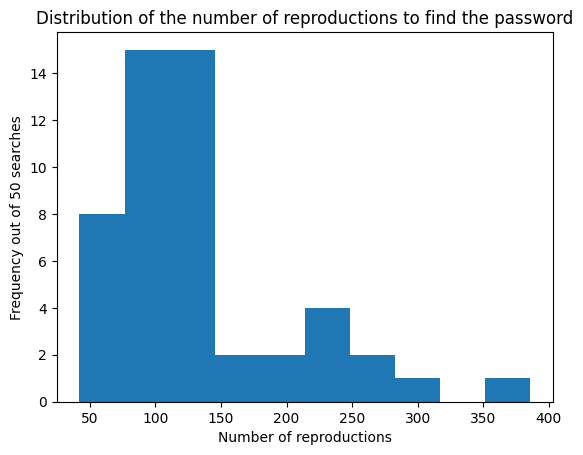


Mean: 129.78
Standard deviation: 10.272810326293387


In [38]:
hist(nRepsList, bins=10)
title("Distribution of the number of reproductions to find the password")
xlabel("Number of reproductions")
ylabel(f"Frequency out of {nIterations} searches")
show()

meanReps = sum(nRepsList)/len(nRepsList)
stdDevReps = sqrt(sum([(n - meanReps)**2 for n in nRepsList]))/len(nRepsList)
print(f"\nMean: {meanReps}\nStandard deviation: {stdDevReps}")

### 3.4. Effect of hyperparameters

In [39]:
def getStats(targetParamList, targetParamName, otherArgs, nIterations=10):
  print("================================================")
  print("Getting stats for parameter:", targetParamName)
  targetParamList = sorted(list(set(targetParamList)))
  # NOTE: The above removes redundant values & sorts the items
  print("\nNumber of unique values to check:", len(targetParamList))

  # Initialising statistics dictionary:
  stats = {"nReps-mean":[], "nReps-stdDev":[],
           "maxFit-mean":[], "maxFit-stdDev":[]}

  # Small helper functions:
  mean = lambda A: sum(A)/len(A)
  stdDev = lambda A, mu: sqrt(sum([(n - mu)**2 for n in A]))/len(A)

  # Main loop:
  print('[', end='')
  for targetParamValue in targetParamList:
    # Instantiating the evolutionary search class:
    args = otherArgs
    args[targetParamName] = targetParamValue
    ES = EvolutionarySearch(**args)

    # EXTRA: Progress bar
    print('.', end='')

    # Obtaining the reproduction stats for the current parameter value:
    nRepsList, maxFitList = [], []
    for i in range(nIterations):
      results = ES.search(nGen=3000,
                          desiredFitness=1.0,
                          init=True,
                          show=False)
      nRepsList.append(results[0])
      maxFitList.append(results[1])

    stats["nReps-mean"].append(mean(nRepsList))
    stats["nReps-stdDev"].append(stdDev(nRepsList, stats["nReps-mean"][-1]))
    stats["maxFit-mean"].append(mean(maxFitList))
    stats["maxFit-stdDev"].append(stdDev(maxFitList, stats["maxFit-mean"][-1]))


  print("]\n")
  return {"value":targetParamList,
          **stats}

<font color="red">**WARNING**</font>: The following code may take some time to run.

In [40]:
from pandas import DataFrame
# The parameters to check:
pMutas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
pCOs = [0.1*i for i in range(1, 11)]
popSizes = [10*i for i in range(1, 11)]
DF = [] # For storing generated data frames (in case we need them later)

In [41]:
DF.append(DataFrame(data=getStats(pMutas, "pMuta", {"pCO":1.0, "popSize":20})))
DF[-1]

Getting stats for parameter: pMuta

Number of unique values to check: 10
[..........]



,value,nReps-mean,nReps-stdDev,maxFit-mean,maxFit-stdDev
0,0.01,749.1,102.252770,1.000000,0.000000
1,0.02,329.3,48.513514,1.000000,0.000000
2,0.03,170.5,11.371236,1.000000,0.000000
3,0.04,188.0,30.174493,1.000000,0.000000
4,0.05,188.6,28.311906,1.000000,0.000000
5,0.10,136.0,16.496060,1.000000,0.000000
6,0.20,179.5,28.226318,1.000000,0.000000
7,0.30,267.3,49.676966,1.000000,0.000000
8,0.40,565.5,53.178990,1.000000,0.000000
9,0.50,1595.5,258.354843,0.998541,0.001384


In [42]:
DF.append(DataFrame(data=getStats(pCOs, "pCO", {"pMuta":0.1, "popSize":20})))
# NOTE: We are using the best pMuta as previously obtained
DF[-1]

Getting stats for parameter: pCO

Number of unique values to check: 10
[..........]



,value,nReps-mean,nReps-stdDev,maxFit-mean,maxFit-stdDev
0,0.1,1133.5,145.525410,1.0,0.0
1,0.2,629.9,77.468503,1.0,0.0
2,0.3,518.3,84.383417,1.0,0.0
3,0.4,296.9,32.415876,1.0,0.0
4,0.5,272.3,19.976511,1.0,0.0
5,0.6,226.8,33.312700,1.0,0.0
6,0.7,164.6,11.149170,1.0,0.0
7,0.8,160.8,18.819564,1.0,0.0
8,0.9,144.9,12.769064,1.0,0.0
9,1.0,113.0,14.167569,1.0,0.0


In [43]:
DF.append(DataFrame(data=getStats(popSizes, "popSize", {"pCO":1.0, "pMuta":0.1})))
# NOTE: We are using the best pMuta & pCO as previously obtained
DF[-1]

Getting stats for parameter: popSize

Number of unique values to check: 10
[..........]



,value,nReps-mean,nReps-stdDev,maxFit-mean,maxFit-stdDev
0,10,256.8,46.529088,1.0,0.0
1,20,107.2,10.619605,1.0,0.0
2,30,78.9,9.349278,1.0,0.0
3,40,56.0,6.013319,1.0,0.0
4,50,51.4,4.630767,1.0,0.0
5,60,33.3,4.619632,1.0,0.0
6,70,45.0,6.018305,1.0,0.0
7,80,27.7,2.498199,1.0,0.0
8,90,26.2,3.393523,1.0,0.0
9,100,31.7,3.423595,1.0,0.0
